In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats

#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import selection_tests

In [2]:
#need to replicate table 3?
school_data = pd.read_stata('aerdata_colombia2.dta')
#keep if checkid==1 & age>=9 & age<=25
school_data = school_data[(school_data['checkid']==1) &
                          (school_data['age']>=9) & (school_data['age']<=25) ]

In [3]:
# Fit the model with ols = True
x_names =['vouch0', 'age', 'sex_name'] 
y_name1 = 'read'
y_name2 = 'math'

#setup x/y for missing data models
x = school_data[x_names].copy()
y1 = school_data[y_name1]
y2 = school_data[y_name2]
missing = school_data['match_i']

print(stats.mode(school_data[y_name1])[0][0])
print(stats.mode(school_data[y_name2])[0][0])

x = sm.add_constant(x[~np.isnan(y1)])
missing = missing[~np.isnan(y1)]
y1 = y1[~np.isnan(y1)]
y2 = y2[~np.isnan(y2)]

print(missing.shape,x.shape)

print(sm.OLS( missing,x).fit(cov_type='HC3').summary())

print(sm.OLS( missing,x[['const','vouch0']]).fit(cov_type='HC3').summary())

0.0
0.0
(3541,) (3541, 4)
                            OLS Regression Results                            
Dep. Variable:                match_i   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     432.5
Date:                Tue, 29 Jun 2021   Prob (F-statistic):          2.46e-239
Time:                        15:18:22   Log-Likelihood:                -2017.6
No. Observations:                3541   AIC:                             4043.
Df Residuals:                    3537   BIC:                             4068.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3819     

/home/erichschulman/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Ks_2sampResult(statistic=0.07132324879436558, pvalue=0.1077673525367023)


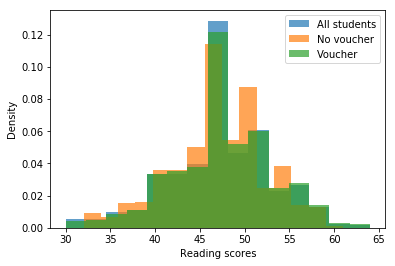

Ks_2sampResult(statistic=0.051824872247407394, pvalue=0.42309160111265276)


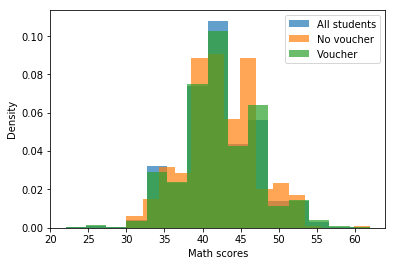

In [8]:
def make_hist(y,x,name):
    cutoff = stats.mode(y)[0][0]
    plt.hist(y[ (y > cutoff)],label='All students',density=True ,alpha=.7,bins=15)
    plt.hist(y[ (y > cutoff)  & (x['vouch0'] ==0) ],label='No voucher',density=True,alpha=.7,bins=15)
    plt.hist(y[ (y > cutoff)  & (x['vouch0'] ==1) ],label='Voucher',density=True,alpha=.7,bins=15)
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(name.replace(' ','_') + '.png')
    print(stats.ks_2samp(y[ (y > cutoff)  & (x['vouch0'] ==0) ],y[ (y > cutoff)  & (x['vouch0'] ==1) ] ))
    plt.show()

make_hist(y1,x,'Reading scores')
make_hist(y2,x,'Math scores')

Optimization terminated successfully.
         Current function value: 1.356813
         Iterations: 114
         Function evaluations: 189
KstestResult(statistic=0.05196732808751792, pvalue=0.0026059252195327304)
Ks_2sampResult(statistic=0.49141455437448894, pvalue=2.383899822016482e-20)


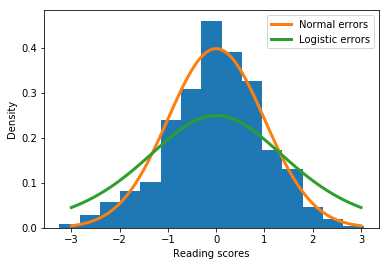

Optimization terminated successfully.
         Current function value: 1.315860
         Iterations: 102
         Function evaluations: 172
KstestResult(statistic=0.06549241835121422, pvalue=5.183847900719123e-05)
Ks_2sampResult(statistic=0.5183673469387755, pvalue=1.3462548678156499e-22)


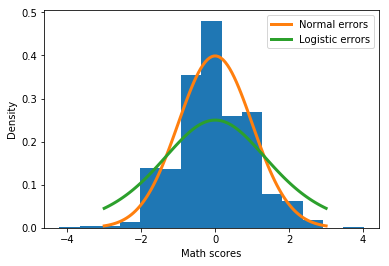

In [13]:
def plot_errors(y,x,name):
    cc_model = selection_tests.Tobit(y,x, cc=True)
    cc_fit  = cc_model.fit()
    cc_resid = cc_model.resid(cc_fit.params)
    standardized = cc_resid[cc_resid != 0]/np.sqrt(cc_fit.params[-1])
    plt.hist(standardized,density=True,bins=15)
    norm_x = np.linspace(-3, 3, 100)
    print(stats.kstest(standardized, stats.norm.cdf))
    print(stats.ks_2samp(standardized, stats.norm.cdf(norm_x,0,1)))
    plt.plot(norm_x, stats.norm.pdf(norm_x, 0,1),linewidth=3,label='Normal errors')
    plt.plot(norm_x, stats.logistic.pdf(norm_x),linewidth=3,label='Logistic errors')
    plt.xlabel(name)
    plt.ylabel('Density')
    plt.legend()
    plt.savefig(name.replace(' ','_') + '_fit.png')
    plt.show()


plot_errors(y1,x,'Reading scores')
plot_errors(y2,x,'Math scores')

In [6]:
def percent_missing(y,x):
    cutoff = stats.mode(y)[0][0]
    age = 0 #predictor
    total = (  (x['age'] > age) ).sum()
    total_missing = ( ( y> cutoff ) & (x['age'] > age) ).sum()
    total_vouch = ((x['vouch0'] ==1) & (x['age'] > age ) ).sum()
    total_no = ( (x['vouch0'] ==0) & (x['age'] > age ) ).sum()
    missing_vouch = ((y > cutoff)  & (x['vouch0'] ==1) & (x['age'] > age ) ).sum()
    missing_no = ((y > cutoff)  & (x['vouch0'] ==0) & (x['age']  > age ) ).sum()
    print(total_missing,missing_vouch,missing_no)
    print(total_missing/total,missing_vouch/total_vouch,missing_no/total_no)
    
percent_missing(y1,x)
percent_missing(y2,x)

1223 779 444
0.3453826602654617 0.37596525096525096 0.30224642614023145
1225 781 444
0.34594747246540525 0.3769305019305019 0.30224642614023145


In [7]:
print(sm.OLS(1*(y1>0),x).fit(cov_type='HC3').summary())
print(sm.OLS( 1*(y2>0),x).fit(cov_type='HC3').summary())

                            OLS Regression Results                            
Dep. Variable:                   read   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     419.7
Date:                Tue, 29 Jun 2021   Prob (F-statistic):          3.09e-233
Time:                        15:18:24   Log-Likelihood:                -2003.3
No. Observations:                3541   AIC:                             4015.
Df Residuals:                    3537   BIC:                             4039.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3468      0.063     37.126      0.0

In [ ]:
#why is the tobit worse?
cc_model1 = selection_tests.Tobit(y1,x, cc=True)
cc_fit1 = cc_model1.fit()
cc_ll1 = cc_model1.loglikeobs(cc_fit1.params)
tobit_model1 = selection_tests.Tobit(y1,x)
tobit_fit1 = tobit_model1.fit()
tobit_ll1 = tobit_model1.loglikeobs(tobit_fit1.params)

-0.42370442821220666
1517    0.0
Name: read, dtype: float32
      const  vouch0   age  sex_name
1517    1.0       0  17.0         0


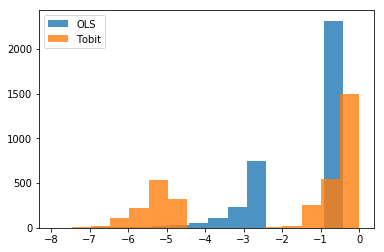

In [55]:
#print( y1[cc_ll1 < -7 ], y1[tobit_ll1 < -7 ] )
#print(cc_ll1.argmax(),cc_ll1.max(),y1[0])
#print(cc_ll1.argmin(),cc_ll1.min(),y1[2341])
#print(cc_ll1[cc_ll1 < -7] )
print(cc_ll1.max())
#print( y1[cc_ll1 == cc_ll1.max()])
print(y1[tobit_ll1 == tobit_ll1.max()])
#print(x[tobit_ll1 == tobit_ll1.max()] )
print( y1[cc_ll1 == cc_ll1.min()],y1[tobit_ll1 == tobit_ll1.min()] )
#print( y1[ (cc_ll1-tobit_ll1) == (cc_ll1-tobit_ll1).min()],y1[(cc_ll1-tobit_ll1) ==(cc_ll1-tobit_ll1).max()] )

plt.hist(cc_ll1,label='OLS',bins=15,alpha =.8)
plt.hist(tobit_ll1,label='Tobit',bins=15,alpha =.8)
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 1.442082
         Iterations: 477
         Function evaluations: 763
[102.77230457   2.05882076  -5.50070892  -0.71779137 104.30727111]


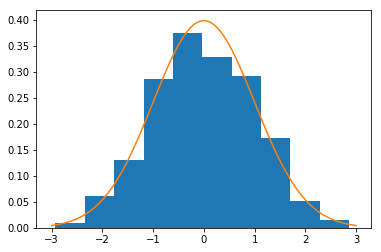

In [44]:
# Fit the model with ols = False
tobit_model = selection_tests.Tobit(y,x)
tobit_fit  = tobit_model.fit()
print(tobit_fit.params)

#why is there randomly a missing observation?
#print(tobit_fit.summary(title='Tobit').as_latex())

tobit_resid = tobit_model.resid(tobit_fit.params)
tobit_resid  = tobit_resid[tobit_resid!=0]
plt.hist( (tobit_resid - tobit_resid.mean() )/np.sqrt( tobit_resid.var()),
         density=True)
norm_x = np.linspace(-3, 3, 100)
plt.plot(norm_x, stats.norm.pdf(norm_x, 0,1))